In [1]:
import os
import warnings
import sys
import tarfile
import urllib.request

import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import mlflow
import mlflow.sklearn

from datetime import datetime
from mlflow.tracking import MlflowClient

client = MlflowClient()
dt = datetime.now().strftime("%d-%m-%Y (%H:%M:%S.%f)")


In [2]:
remote_server_uri = "http://127.0.0.1:5000"
mlflow.set_tracking_uri(remote_server_uri)
mlflow.tracking.get_tracking_uri()

'http://127.0.0.1:5000'

In [7]:
exp_name = "Housing_prices prediction"
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='Housing_prices prediction', tags={}>

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [5]:
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = "Housing Project Images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"Images",CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def eval_metrics(actual, pred):
    # compute relevant metrics
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

def load_data(housing_path):

    csv_path = os.path.join(housing_path, "housing.csv")
    housing = pd.read_csv(csv_path)

    %matplotlib inline
    import matplotlib.pyplot as plt
    housing.hist(bins=50, figsize=(20,15))
    save_fig("attribute_histogram_plots")
    plt.show()

    housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

    np.random.seed(42)

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]
    
    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis=1, inplace=True)

    attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
    scatter_matrix(housing[attributes], figsize=(12, 8))
    save_fig("scatter_matrix_plot")

    housing = strat_train_set.drop("median_house_value", axis=1)
    housing_labels = strat_train_set["median_house_value"].copy()

    attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
    housing_extra_attribs = attr_adder.transform(housing.values)

    col_names = "total_rooms", "total_bedrooms", "population", "households"
    rooms_ix, bedrooms_ix, population_ix, households_ix = [
        housing.columns.get_loc(c) for c in col_names]
    housing_extra_attribs = pd.DataFrame(
        housing_extra_attribs,
        columns=list(housing.columns)+["rooms_per_household", "population_per_household","bedrooms_per_room"], index=housing.index)
    housing = housing_extra_attribs

    housing_num = housing.drop("ocean_proximity", axis=1)
    housing_cat = housing[["ocean_proximity"]]
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

    num_attribs = list(housing_num)
    cat_attribs = ["ocean_proximity"]
    
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
    
    housing_prepared = full_pipeline.fit_transform(housing)

    housing_test = strat_test_set.drop("median_house_value", axis=1)
    housing_test_labels = strat_test_set["median_house_value"].copy()

    attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
    housing_test_extra_attribs = attr_adder.transform(housing_test.values)

    col_names = "total_rooms", "total_bedrooms", "population", "households"
    rooms_ix, bedrooms_ix, population_ix, households_ix = [
        housing_test.columns.get_loc(c) for c in col_names]
    housing_test_extra_attribs = pd.DataFrame(
        housing_test_extra_attribs,
        columns=list(housing_test.columns)+["rooms_per_household", "population_per_household","bedrooms_per_room"], index=housing_test.index)
    housing_test = housing_test_extra_attribs

    housing_test_num = housing_test.drop("ocean_proximity", axis=1)
    housing_test_cat = housing_test[["ocean_proximity"]]

    num_test_attribs = list(housing_test_num)
    cat_test_attribs = ["ocean_proximity"]
    
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_test_attribs),
        ("cat", OneHotEncoder(), cat_test_attribs),
    ])
    
    housing_test_prepared = full_pipeline.fit_transform(housing_test)

    return housing_prepared, housing_labels, housing_test_prepared, housing_test_labels

def train(model_no):
    warnings.filterwarnings("ignore")
    np.random.seed(42)

    DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
    HOUSING_PATH = os.path.join("datasets","housing")
    HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

    housing_path = HOUSING_PATH
    housing_url = HOUSING_URL

    #if not os.path.isdir(housing_path):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

    train_x, train_y, test_x, test_y = load_data(HOUSING_PATH)

    if model_no == 1:

            with mlflow.start_run(run_name='CHILD_RUN', nested=True) as child_run:
                mlflow.log_param("child", "yes")

                lr = LinearRegression()
                lr.fit(train_x, train_y)

                predicted_qualities = lr.predict(test_x)
                (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

                print("  RMSE: %s" % rmse)
                print("  MAE: %s" % mae)
                print("  R2: %s" % r2)

                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.log_artifact(housing_path)
                print("Save to: {}".format(mlflow.get_artifact_uri()))

                mlflow.sklearn.log_model(lr, "model")

                _run = client.get_run(run_id=child_run.info.run_id)
                client.set_tag(_run.info.run_id, "deployed", dt)

                print("parent run_id: {}".format(parent_run.info.run_id))
                print("child run_id : {}".format(child_run.info.run_id))
                print("--")

                query = "tags.mlflow.parentRunId = '{}'".format(parent_run.info.run_id)
                results = mlflow.search_runs(filter_string=query)
                print(results[["run_id", "params.child", "tags.mlflow.runName"]])

    if model_no == 2:

            with mlflow.start_run(run_name='CHILD_RUN', nested=True) as child_run:
                mlflow.log_param("child", "yes")

                tree_reg = DecisionTreeRegressor(random_state=42)
                tree_reg.fit(train_x, train_y)

                predicted_qualities = tree_reg.predict(test_x)
                (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

                print("  RMSE: %s" % rmse)
                print("  MAE: %s" % mae)
                print("  R2: %s" % r2)

                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.log_artifact(housing_path)
                print("Save to: {}".format(mlflow.get_artifact_uri()))

                mlflow.sklearn.log_model(tree_reg, "model")

                _run = client.get_run(run_id=child_run.info.run_id)
                client.set_tag(_run.info.run_id, "deployed", dt)

                print("parent run_id: {}".format(parent_run.info.run_id))
                print("child run_id : {}".format(child_run.info.run_id))
                print("--")

                query = "tags.mlflow.parentRunId = '{}'".format(parent_run.info.run_id)
                results = mlflow.search_runs(filter_string=query)
                print(results[["run_id", "params.child", "tags.mlflow.runName"]])

    if model_no == 3:

            with mlflow.start_run(run_name='CHILD_RUN', nested=True) as child_run:
                mlflow.log_param("child", "yes")

                forest_reg = RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)
                forest_reg.fit(train_x, train_y)

                predicted_qualities = forest_reg.predict(test_x)
                (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

                print("  RMSE: %s" % rmse)
                print("  MAE: %s" % mae)
                print("  R2: %s" % r2)

                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.log_artifact(housing_path)
                print("Save to: {}".format(mlflow.get_artifact_uri()))

                mlflow.sklearn.log_model(forest_reg, "model")

                _run = client.get_run(run_id=child_run.info.run_id)
                client.set_tag(_run.info.run_id, "deployed", dt)

                print("parent run_id: {}".format(parent_run.info.run_id))
                print("child run_id : {}".format(child_run.info.run_id))
                print("--")

                query = "tags.mlflow.parentRunId = '{}'".format(parent_run.info.run_id)
                results = mlflow.search_runs(filter_string=query)
                print(results[["run_id", "params.child", "tags.mlflow.runName"]])

    if model_no == 4:

            with mlflow.start_run(run_name='CHILD_RUN', nested=True) as child_run:
                mlflow.log_param("child", "yes")

                svr_reg = SVR(C=157055.10989448498, kernel="rbf", gamma=0.26497040005002437)
                svr_reg.fit(train_x, train_y)

                predicted_qualities = svr_reg.predict(test_x)
                (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

                print("  RMSE: %s" % rmse)
                print("  MAE: %s" % mae)
                print("  R2: %s" % r2)

                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.log_artifact(housing_path)
                print("Save to: {}".format(mlflow.get_artifact_uri()))

                mlflow.sklearn.log_model(svr_reg, "model")

                _run = client.get_run(run_id=child_run.info.run_id)
                client.set_tag(_run.info.run_id, "deployed", dt)

                print("parent run_id: {}".format(parent_run.info.run_id))
                print("child run_id : {}".format(child_run.info.run_id))
                print("--")

                query = "tags.mlflow.parentRunId = '{}'".format(parent_run.info.run_id)
                results = mlflow.search_runs(filter_string=query)
                print(results[["run_id", "params.child", "tags.mlflow.runName"]])


Saving figure attribute_histogram_plots


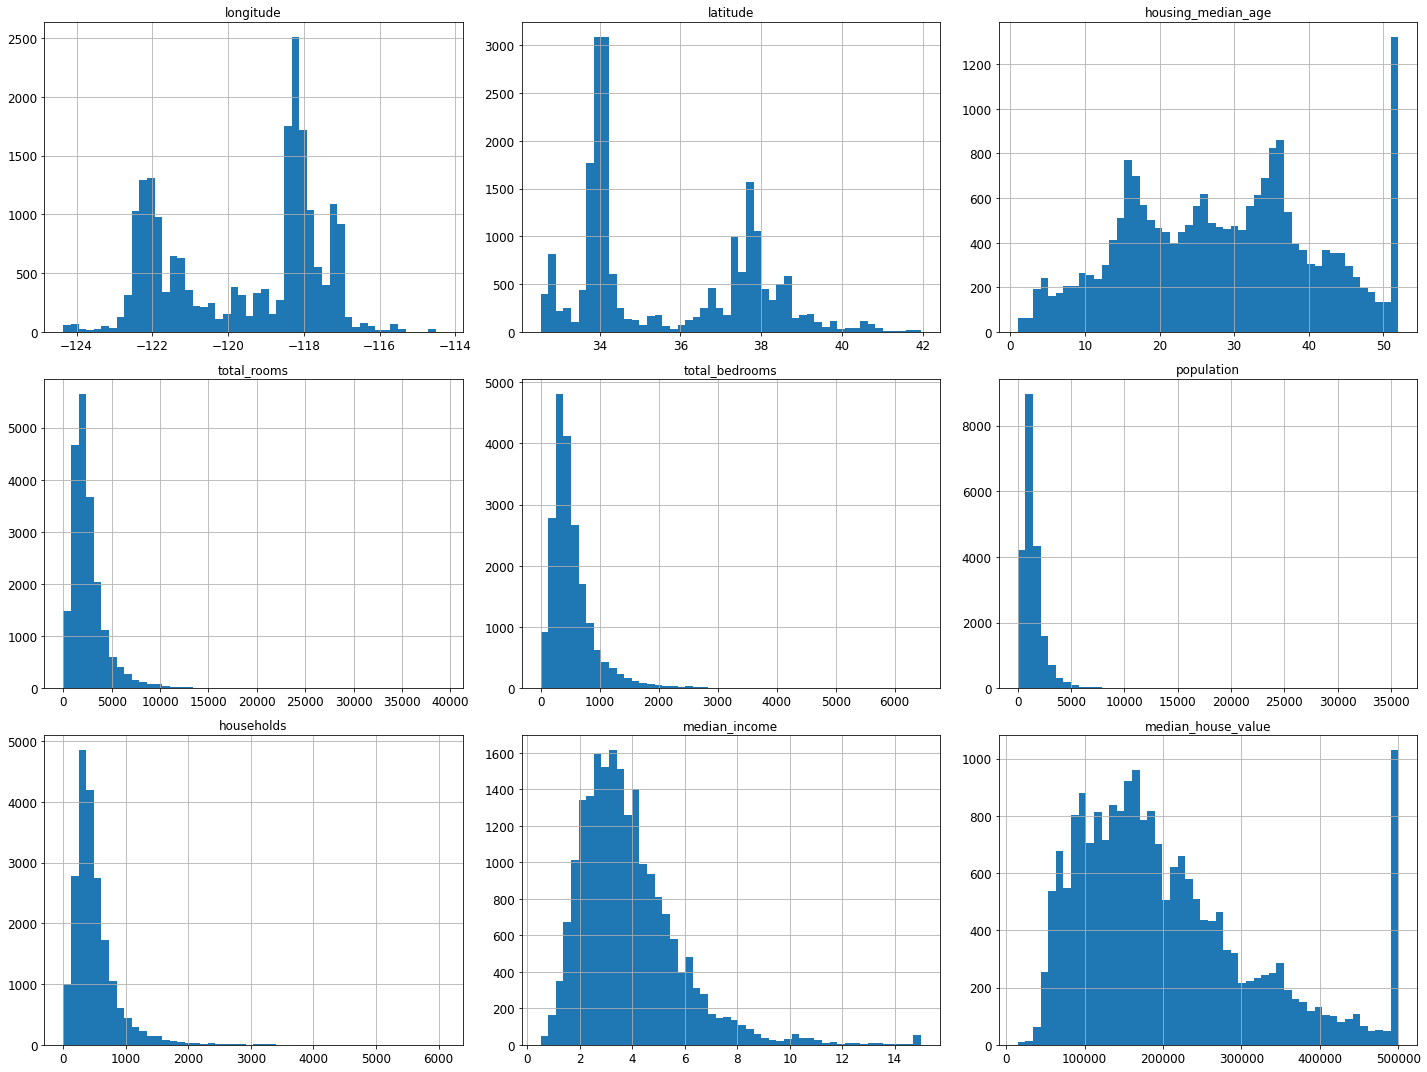

Saving figure scatter_matrix_plot
  RMSE: 66844.3621005924
  MAE: 49005.22177810078
  R2: 0.6571689350914249
Save to: ./mlruns/2/d9ea6323957842198362ceef6cba1209/artifacts
parent run_id: 4b97052091724fab8409a30647da3c3d
child run_id : d9ea6323957842198362ceef6cba1209
--
                             run_id params.child tags.mlflow.runName
0  d9ea6323957842198362ceef6cba1209          yes           CHILD_RUN
Saving figure attribute_histogram_plots


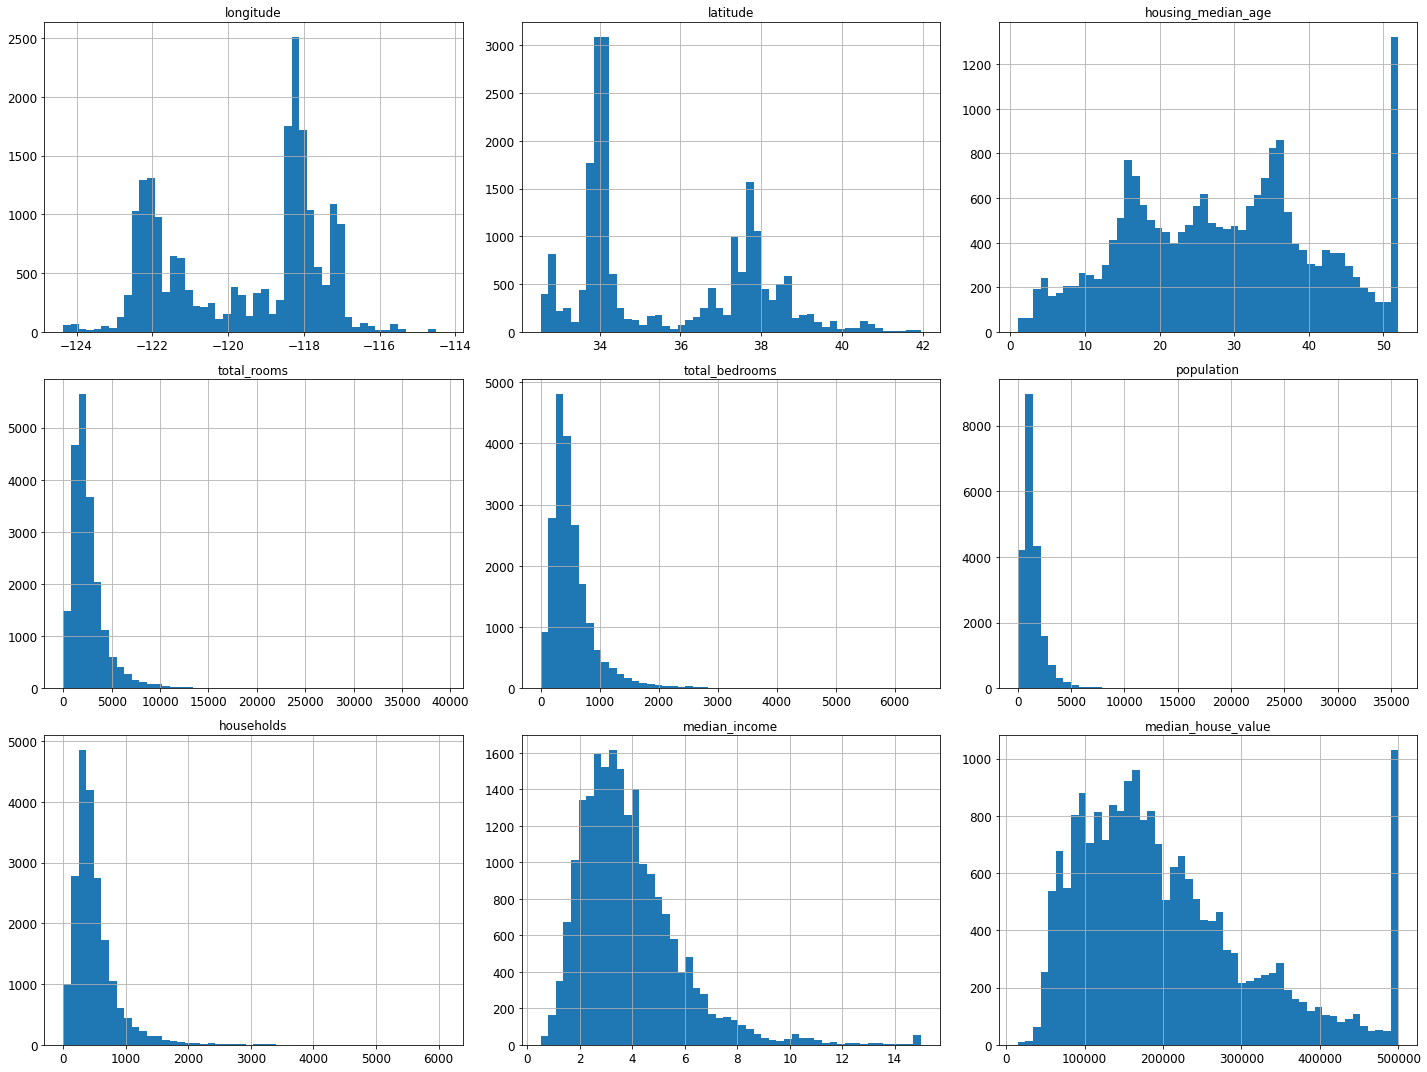

Saving figure scatter_matrix_plot
  RMSE: 107571.75706220746
  MAE: 73254.00581395348
  R2: 0.11213461171598615
Save to: ./mlruns/2/c85351d89d274b498d67b485901f50e6/artifacts
parent run_id: 4b97052091724fab8409a30647da3c3d
child run_id : c85351d89d274b498d67b485901f50e6
--
                             run_id params.child tags.mlflow.runName
0  c85351d89d274b498d67b485901f50e6          yes           CHILD_RUN
1  d9ea6323957842198362ceef6cba1209          yes           CHILD_RUN
Saving figure attribute_histogram_plots


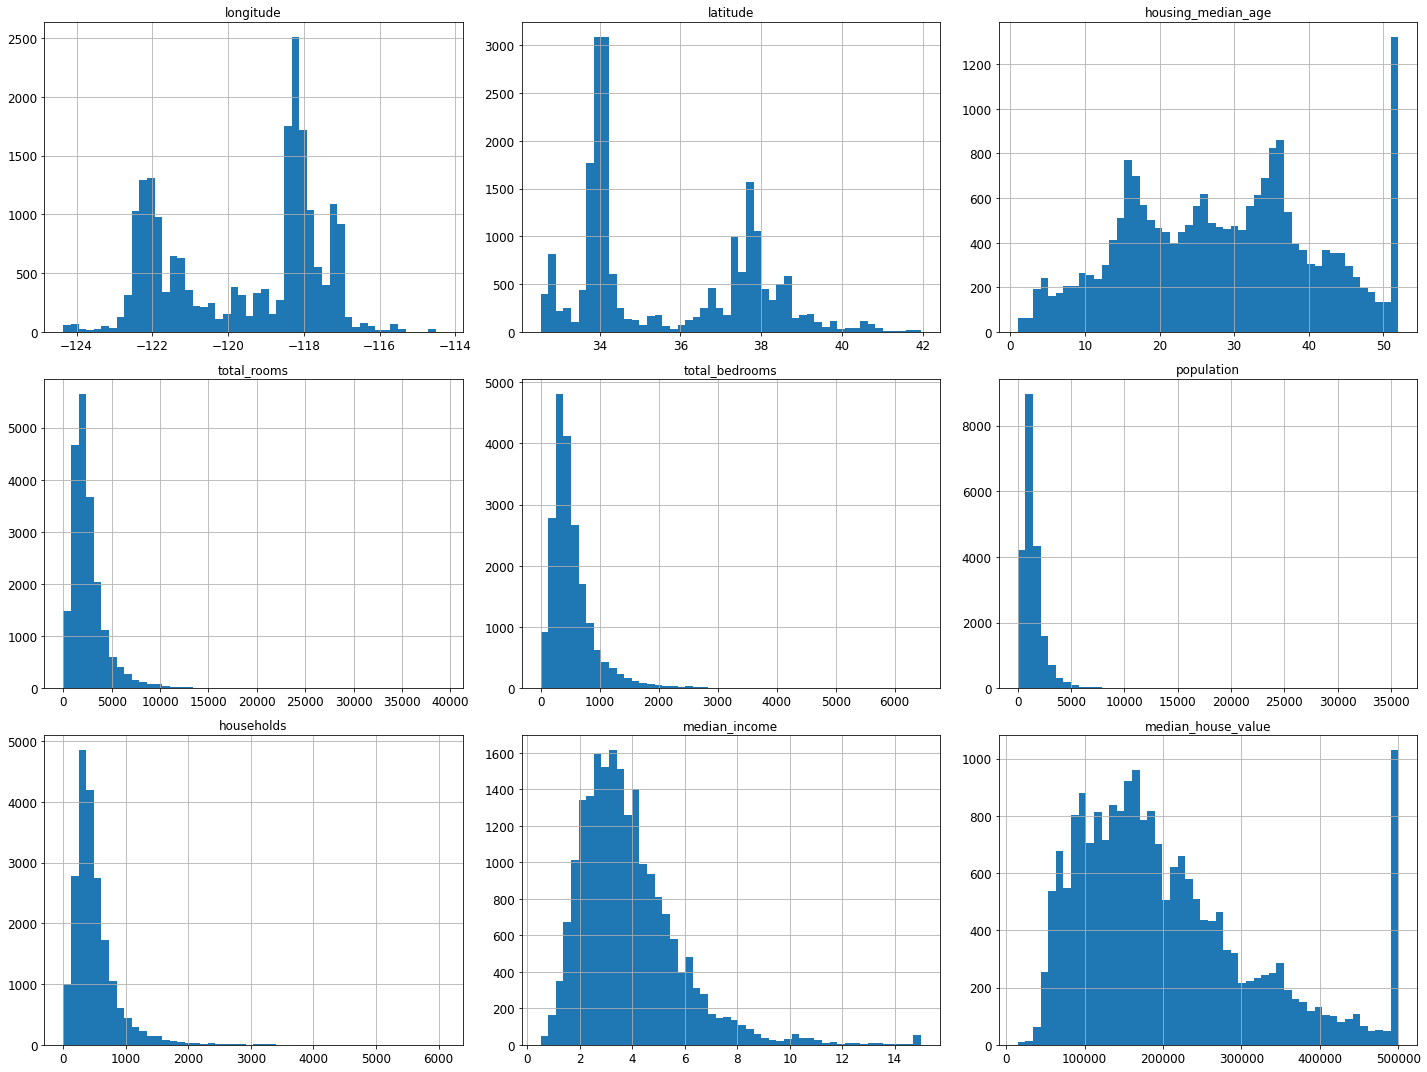

Saving figure scatter_matrix_plot
  RMSE: 72125.39056148597
  MAE: 54142.15138081396
  R2: 0.6008584337443713
Save to: ./mlruns/2/b8b03213ab8e44d2990f6e9225fb5a80/artifacts
parent run_id: 4b97052091724fab8409a30647da3c3d
child run_id : b8b03213ab8e44d2990f6e9225fb5a80
--
                             run_id params.child tags.mlflow.runName
0  b8b03213ab8e44d2990f6e9225fb5a80          yes           CHILD_RUN
1  c85351d89d274b498d67b485901f50e6          yes           CHILD_RUN
2  d9ea6323957842198362ceef6cba1209          yes           CHILD_RUN
Saving figure attribute_histogram_plots


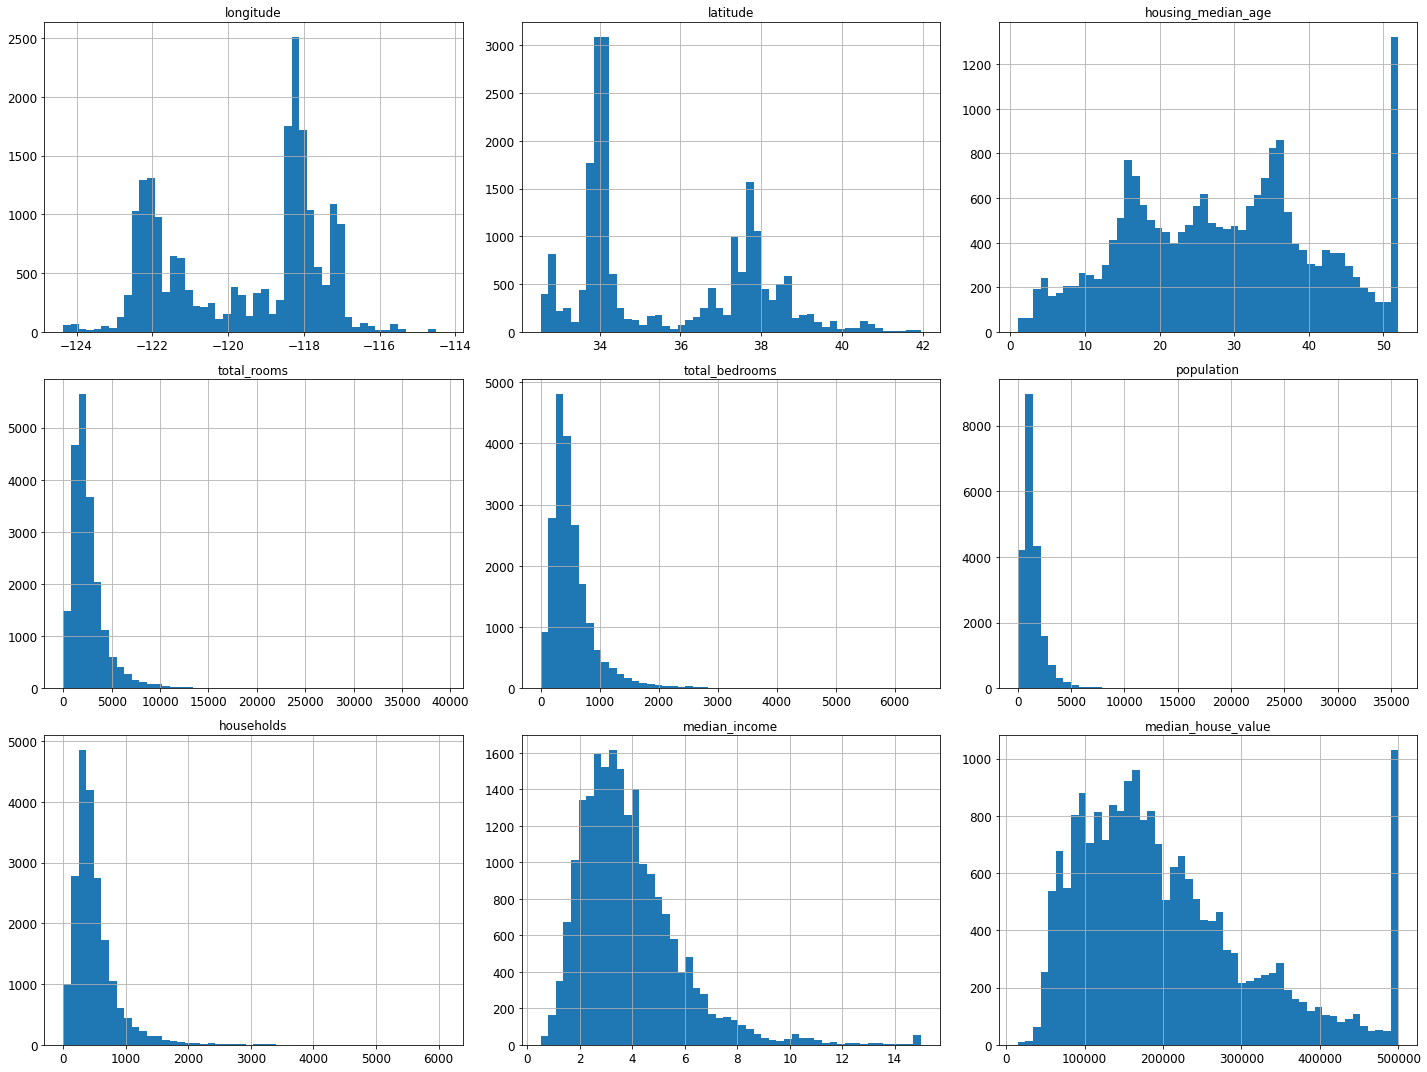

Saving figure scatter_matrix_plot
  RMSE: 56300.252284589675
  MAE: 39832.47806380019
  R2: 0.7567956809279797
Save to: ./mlruns/2/033960fd1fa44ff09eaabbf2759fbe18/artifacts
parent run_id: 4b97052091724fab8409a30647da3c3d
child run_id : 033960fd1fa44ff09eaabbf2759fbe18
--
                             run_id params.child tags.mlflow.runName
0  033960fd1fa44ff09eaabbf2759fbe18          yes           CHILD_RUN
1  b8b03213ab8e44d2990f6e9225fb5a80          yes           CHILD_RUN
2  c85351d89d274b498d67b485901f50e6          yes           CHILD_RUN
3  d9ea6323957842198362ceef6cba1209          yes           CHILD_RUN


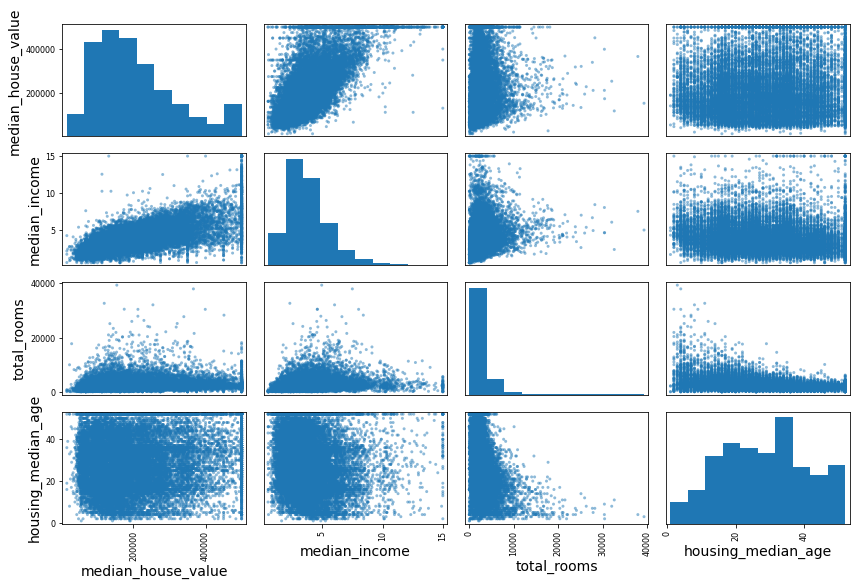

In [6]:
with mlflow.start_run(run_name='PARENT_RUN') as parent_run:
    mlflow.log_param("parent", "yes")
    train(1)
    train(2)
    train(3)
    train(4)